<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h3><center>Clément VERON | Thomas Bodart | Marc Garcia</center></h3>
<h1>
<hr style=" border:none; height:3px;">
<center>Graph mining project</center>
<hr style=" border:none; height:3px;">
</h1>


Outline des ajouts :

    - Analyse de la matrice de corrélation entre les différentes centralités

    - Analyse de certains noeuds ayant de grande valeur de centralité

    - Comparaison des rangs de centralités aux clusters calculés par k-means

    - Calcul de la clique maximale et ajout de la comparaison avec l'algorithme des k-cliques

    - Changement d'implémentation pour le calcul de l'embedding spectral avec choix judicieux du nombre de plus petits vecteurs propres sélectionnés.

    - Comparaison des deux embeddings (spectral & Node2Vec) par deux approches : modularité du clustering et prédiction de lien.

    - Justification des choix d'hyperparamètres pour les algorithmes de clustering (KMeans & DBSCAN)

Outline du projet :

0- Installation des packages

1- Chargement des données

2- Centralités <br>
2.1 - Deezer Europe Centralities<br>
2.2 - Lastfm Graph Centralities

3- Community detection<br>
3.1- 8-clique community<br>
3.2- Louvain communities

4- Embeddings<br>
4.1- Node2Vec embedding<br>
4.2- Spectral embedding

5- Comparaison des embeddings<br>
5.1 Comparaison des clusters dans l'espace des embeddings<br>
5.2 Link prediction

6- GNN-based approach<br>
6.1 Deezer<br>
6.2 LastFM

# 0- Installation des packages

In [ ]:
# ! pip install networkx
# ! pip install matplotlib
# ! pip install scipy
# ! pip install gensim
# ! pip install node2vec
# ! pip install scikit-learn
# ! pip install numpy 
# ! pip install tqdm
# ! pip install seaborn
# ! pip install torch
# ! pip install random
# ! pip install collections

ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


# 1- Chargement des données

In [2]:
import os
from pathlib import Path
import networkx as nx
import json

file_dir = Path(os.getcwd()) 
lastfm_data_path = file_dir / "lastfm_asia"
deezer_data_path = file_dir / "deezer_europe"

assert os.path.isdir(
    deezer_data_path
), f"Deezer data path is missing: {deezer_data_path}"
assert os.path.isdir(
    lastfm_data_path
), f"LastFM data path is missing: {lastfm_data_path}"

lastfm_edges_path = lastfm_data_path / "lastfm_asia_edges.csv"
deezer_edges_path = deezer_data_path / "deezer_europe_edges.csv"
lastfm_nattr_path = lastfm_data_path / "lastfm_asia_features.json"
deezer_nattr_path = deezer_data_path / "deezer_europe_features.json"

assert os.path.exists(
    deezer_edges_path
), f"Deezer edges file is missing: {deezer_edges_path}"
assert os.path.exists(
    lastfm_edges_path
), f"LastFM edges file is missing: {lastfm_edges_path}"


def read_edges(file_path):
    edges = []
    with open(file_path, "r") as file:
        next(file)
        for line in file:
            source, target = line.strip().split(",")
            edges.append((int(source), int(target)))
    return edges


lastfm_edges = read_edges(lastfm_edges_path)
deezer_edges = read_edges(deezer_edges_path)

deezer_graph: nx.graph.Graph = nx.from_edgelist(deezer_edges)
lastfm_graph: nx.graph.Graph = nx.from_edgelist(lastfm_edges)

with open(deezer_nattr_path, "r") as f:
    deezer_node_attributes = json.load(f)

with open(lastfm_nattr_path, "r") as f:
    lastfm_node_attributes = json.load(f)

for node_idx, node_features in deezer_node_attributes.items():
    deezer_graph.nodes[int(node_idx)]["feat"] = node_features

for node_idx, node_features in lastfm_node_attributes.items():
    lastfm_graph.nodes[int(node_idx)]["feat"] = node_features


print("Deezer graph : ", deezer_graph)
print("Lastfm graph : ", lastfm_graph)


Deezer graph :  Graph with 28281 nodes and 92752 edges
Lastfm graph :  Graph with 7624 nodes and 27806 edges


# 2- Centralités

In [4]:
def compute_all_centralities(graph):
    centralities = {}

    # Calcul de l'ensemble des centralités
    degree_centrality = nx.degree_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=100, tol=1e-05)
    katz_centrality = nx.katz_centrality(graph, alpha=0.02, beta=1.0, max_iter=1000, tol=1e-05)
    pagerank_centrality = nx.pagerank(graph)
    clustering_centrality = nx.clustering(graph)
    neighborhood_connectivity = nx.average_neighbor_degree(graph)

    # Création d'un dictionnaire des centralités
    centrality_measures = {
        "degree": degree_centrality,
        "eigenvector": eigenvector_centrality,
        "katz": katz_centrality,
        "pagerank": pagerank_centrality,
        "clustering": clustering_centrality,
        "neighborhood": neighborhood_connectivity
    }

    for node in graph.nodes():
        centralities[node] = {}

    # Calcul des rankings pour l'ensemble des centralités
    for centrality_type, values in centrality_measures.items():
        sorted_nodes = sorted(values, key=values.get, reverse=True) 
        ranking = {node: rank + 1 for rank, node in enumerate(sorted_nodes)} 
        
        # Ajout des valeurs et du rang de chaque noeud pour toutes les centralités
        for node in graph.nodes():
            centralities[node][centrality_type] = {
                "rank": ranking[node],
                "value": values[node]
            }
    
    return centralities

deezer_centralities = compute_all_centralities(deezer_graph)
lastfm_centralities = compute_all_centralities(lastfm_graph)

## 2.1 - Deezer Europe Centralities

/Users/tombo/Desktop/CS_cours/graph_mining/.venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


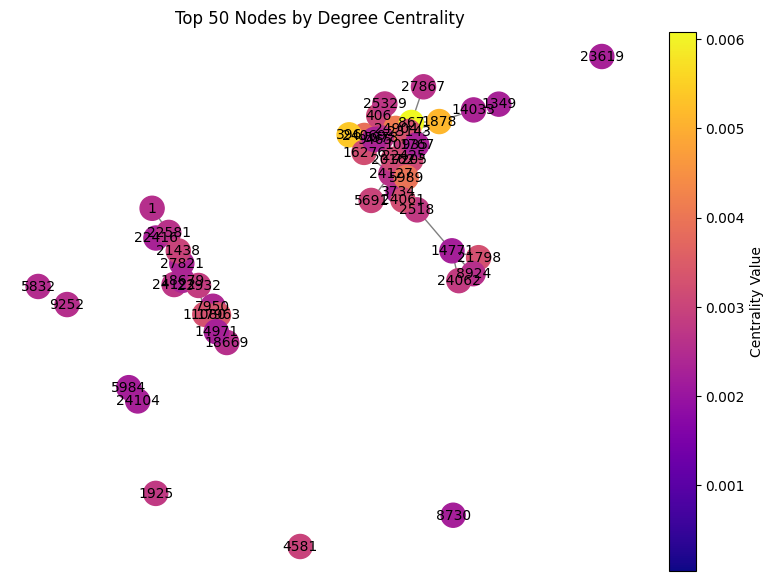

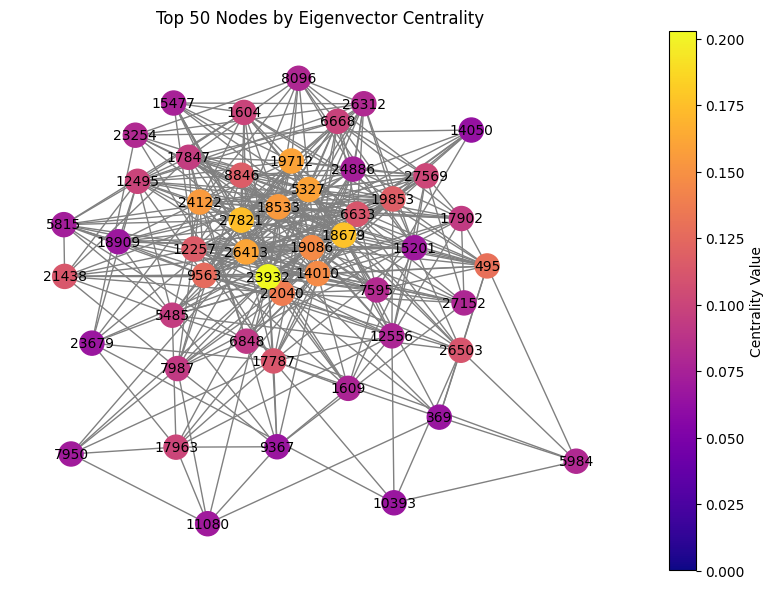

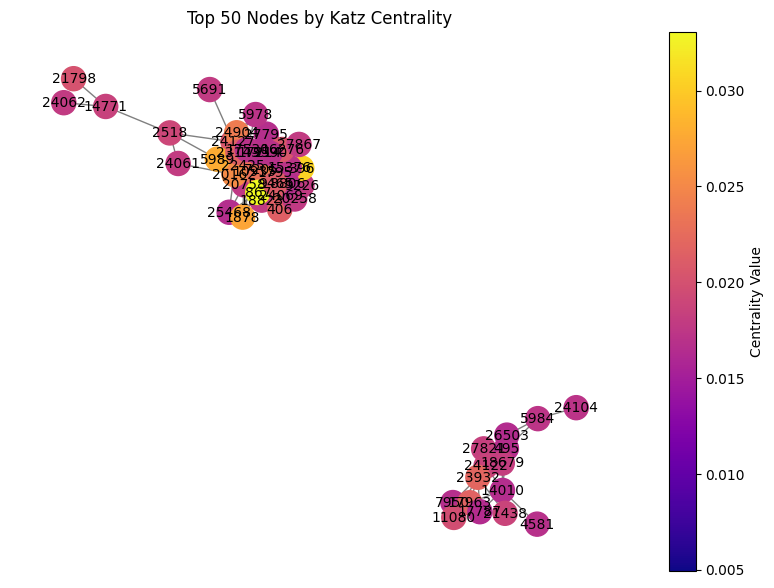

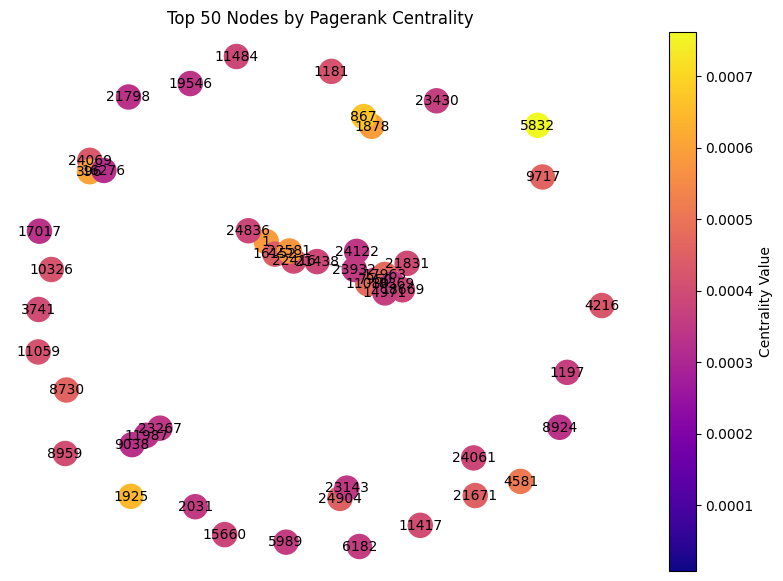

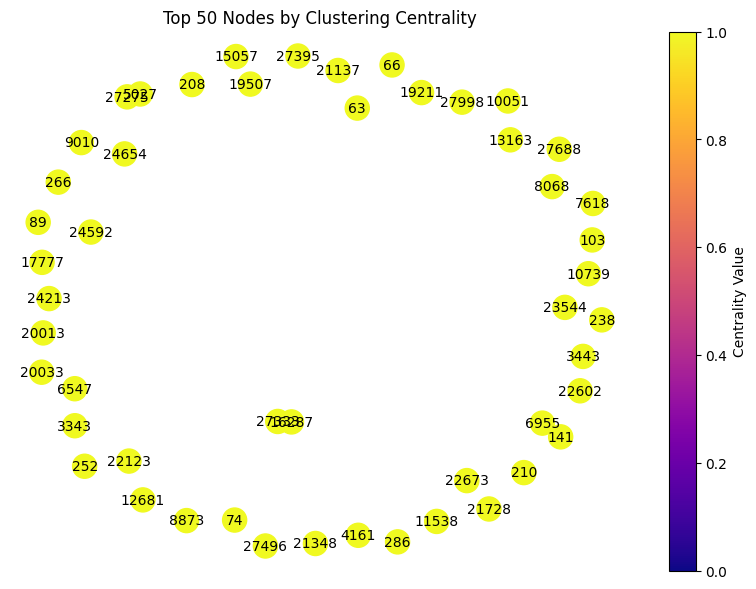

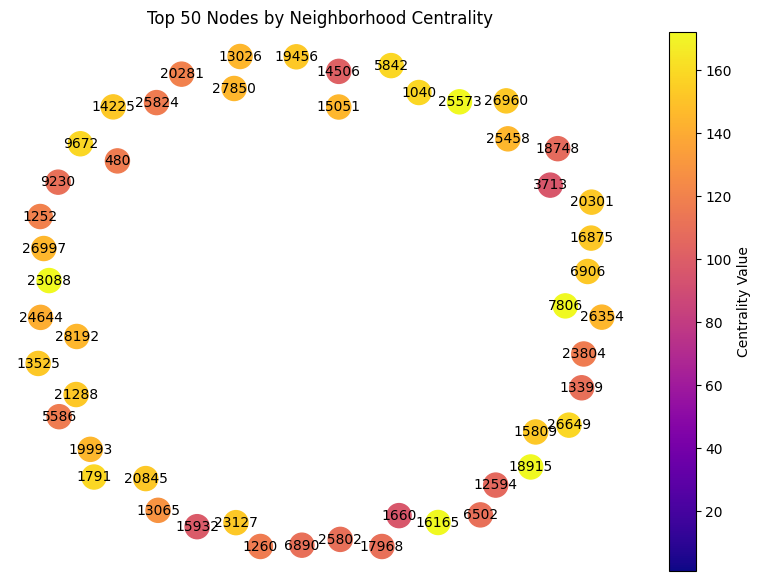

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def extract_top_subgraph(graph, centrality_dict, centrality_type, top_n=50):
    """Extracts a subgraph with the top N nodes based on a chosen centrality measure."""
    centrality_values = {node: data[centrality_type]["value"] for node, data in centrality_dict.items()}
    top_nodes = sorted(centrality_values, key=centrality_values.get, reverse=True)[:top_n]
    return graph.subgraph(top_nodes), centrality_values

def visualize_graph(graph, centrality_values, title="Graph Visualization"):
    """Visualizes the graph with node color and size based on a chosen centrality measure."""
    plt.figure(figsize=(10, 7))
    ax = plt.gca()

    # Mapping des centralités avec des couleurs
    centrality_array = np.array(list(centrality_values.values()))
    norm = plt.Normalize(vmin=centrality_array.min(), vmax=centrality_array.max())
    cmap = plt.cm.plasma 
    node_colors = [cmap(norm(centrality_values[node])) for node in graph.nodes()]

    pos = nx.spring_layout(graph, seed=42)

    nx.draw(graph, pos, with_labels=True, node_color=node_colors, edge_color="gray",
            font_size=10, cmap=cmap, ax=ax)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    plt.colorbar(sm, ax=ax, label="Centrality Value")

    plt.title(title)
    plt.show()


# Select centrality type for visualization
chosen_centralities = ["degree", "eigenvector", "katz", "pagerank", "clustering", "neighborhood"]

for chosen_centrality in chosen_centralities:
    subgraph, subgraph_centrality_values = extract_top_subgraph(deezer_graph, deezer_centralities, chosen_centrality)
    visualize_graph(subgraph, subgraph_centrality_values, title=f"Top 50 Nodes by {chosen_centrality.capitalize()} Centrality")



In [ ]:
import pandas as pd

# Transformation en DataFrame
rows = []
for node, cent_values in deezer_centralities.items():
    row = {'node': node}
    for cent_name, metrics in cent_values.items():
        row[f'{cent_name}_value'] = metrics['value']
        row[f'{cent_name}_rank'] = metrics['rank']
    rows.append(row)

df = pd.DataFrame(rows)
df.set_index('node', inplace=True)


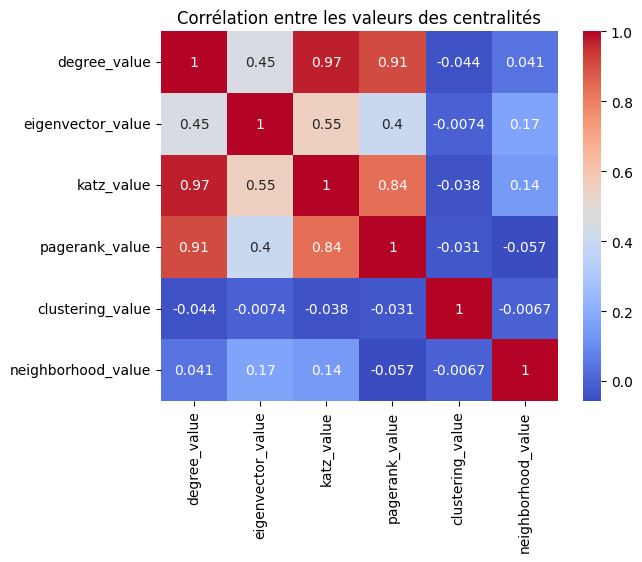

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Corrélation entre centralités (valeurs)
value_cols = [col for col in df.columns if col.endswith('_value')]
sns.heatmap(df[value_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre les valeurs des centralités")
plt.show()


La matrice de corrélation des différentes centalités nous apporte différentes informations, on voit notamment que la degree_centrality, la katz_centrality et la pagerank_centrality sont extrêmement corrélées au contraire de la neighborhood_centrality et de la clustering_centrality ce qui provient du calcul intrinsèque des différentes centralités.

Coefficient directeur : 4.653117473452497
Ordonnée à l'origine : 0.0047135163030782145


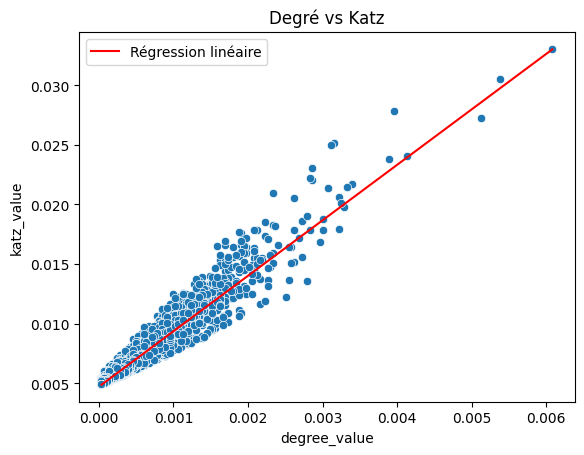

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

slope, intercept = np.polyfit(df['degree_value'], df['katz_value'], 1)

print(f"Coefficient directeur : {slope}")
print(f"Ordonnée à l'origine : {intercept}")

sns.scatterplot(x='degree_value', y='katz_value', data=df)
x_vals = np.linspace(df['degree_value'].min(), df['degree_value'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', label='Régression linéaire')
plt.title("Degré vs Katz")
plt.legend()
plt.show()

On voit ici bien la corrélation entre les deux centralités avec un facteur 4.65 ce qui signifie que les deux centralités amènent la même information de manière générale.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df[value_cols]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Nœuds avec des valeurs particulièrement fortes/faibles
top_degree = df['degree_rank'].nsmallest(10)
low_pagerank = df['pagerank_rank'].nlargest(10)

special_nodes = list(set(top_degree.index) | set(low_pagerank.index))
df.loc[special_nodes]

,degree_value,degree_rank,eigenvector_value,eigenvector_rank,katz_value,katz_rank,pagerank_value,pagerank_rank,clustering_value,clustering_rank,neighborhood_value,neighborhood_rank,cluster
node,,,,,,,,,,,,,
24069,0.003890,6,0.029884,154,0.023843,8,0.000429,16,0.022686,14573,18.790909,7028,2
7045,0.000035,25084,0.000173,11753,0.005045,22093,0.000008,28280,0.000000,22860,33.000000,1779,0
27783,0.000035,26445,0.000046,18026,0.005016,23170,0.000008,28273,0.000000,25570,26.000000,3234,1
24904,0.004137,4,0.020794,267,0.024026,7,0.000454,13,0.013263,14921,17.794872,7869,2
11080,0.003289,9,0.070278,43,0.019749,19,0.000477,9,0.033427,14087,17.290323,8366,2
1865,0.000035,23236,0.000088,15235,0.005086,20165,0.000008,28274,0.000000,17922,45.000000,726,0
396,0.005375,2,0.046768,82,0.030564,2,0.000603,4,0.021436,14705,16.618421,9132,2
20110,0.000035,27040,0.000193,11167,0.005058,21428,0.000008,28281,0.000000,26649,36.000000,1392,0
1878,0.005127,3,0.020457,272,0.027250,4,0.000592,5,0.015709,14859,13.986207,12758,2


Le noeud 867 possède la plus grande degree_centrality et katz_centrality, il est également classé deuxième sur la pagerank_centrality. Néanmoins, il possède un rang assez peu élevé pour les deux dernières centralité.

On voit également que les différents noeuds soit bien classés soit mal classés sont dans des clusters différents resp cluster 2 et cluster 0 ce qui est corrobore nos mesures de centralités.

## 2.2 - Lastfm Graph Centralities

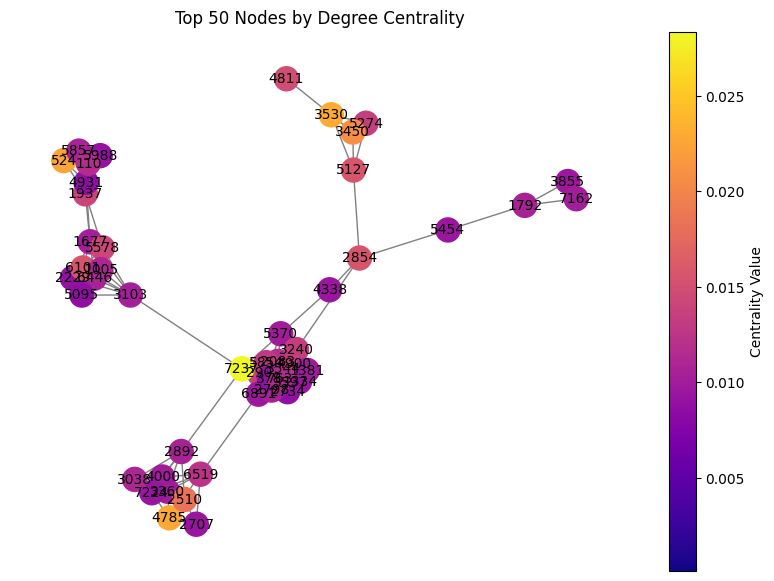

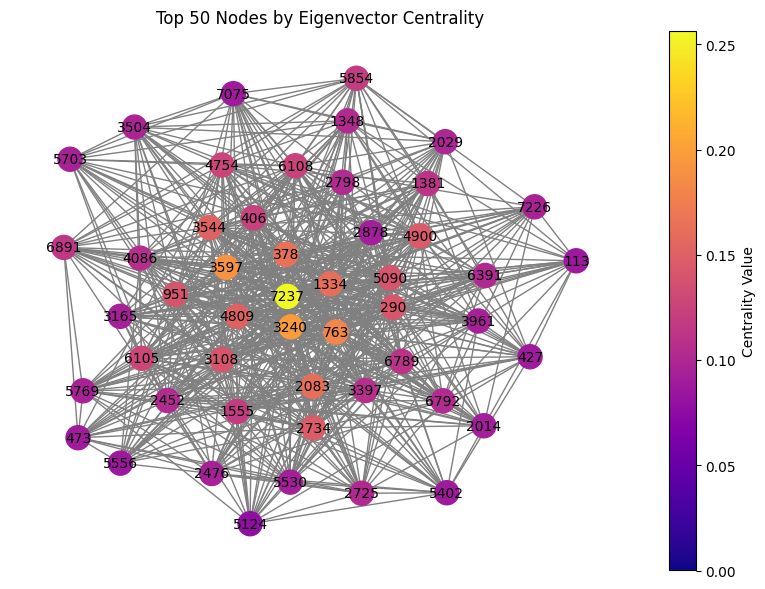

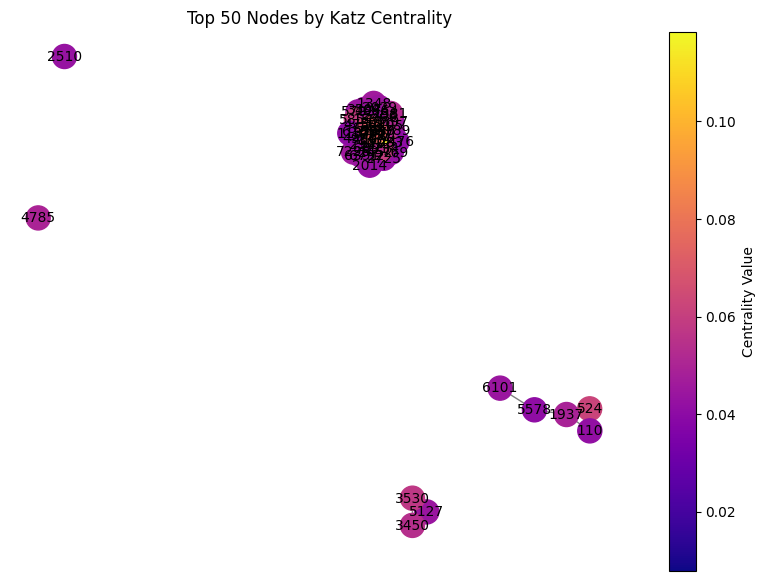

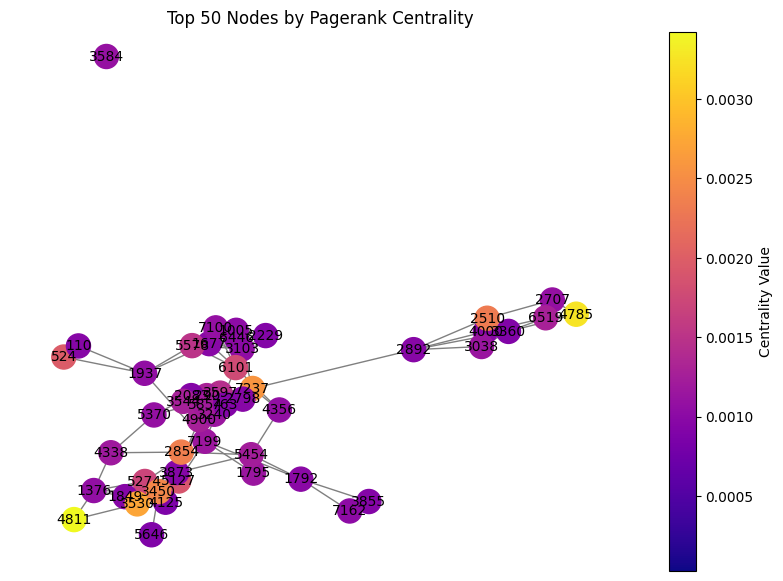

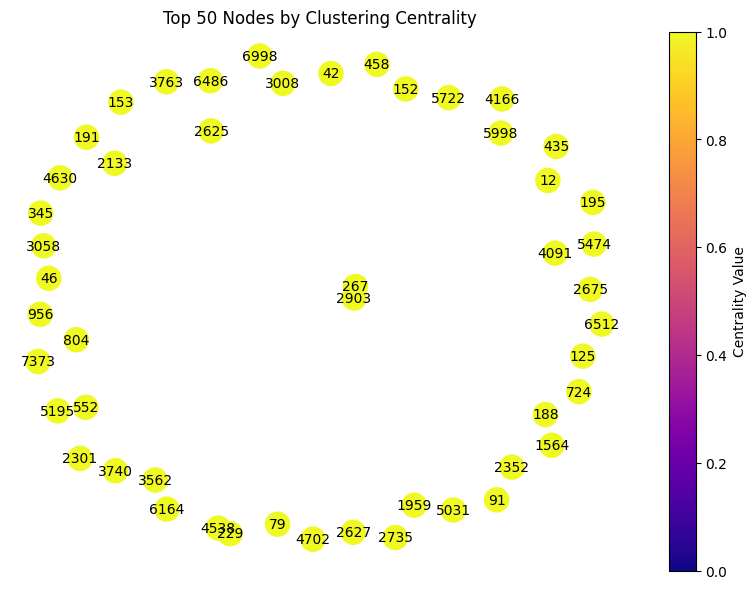

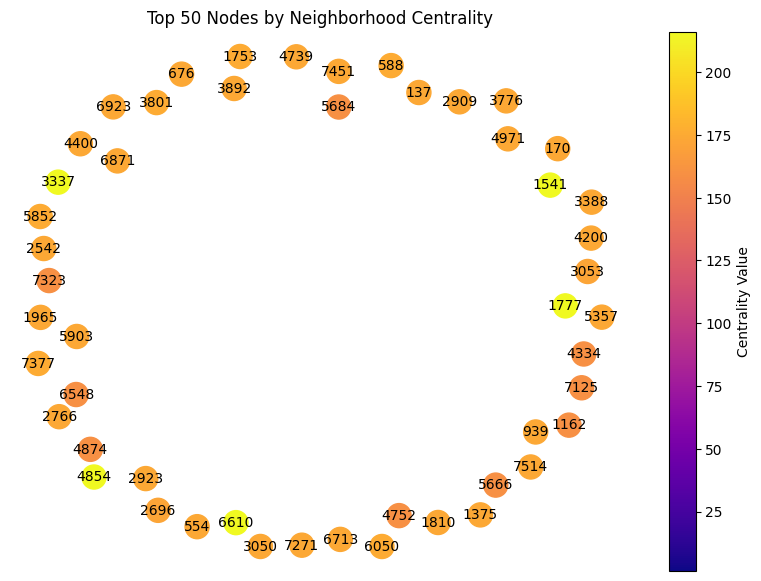

In [5]:
# Select centrality type for visualization
chosen_centralities = ["degree", "eigenvector", "katz", "pagerank", "clustering", "neighborhood"]

for chosen_centrality in chosen_centralities:
    subgraph, subgraph_centrality_values = extract_top_subgraph(lastfm_graph, lastfm_centralities, chosen_centrality)
    visualize_graph(subgraph, subgraph_centrality_values, title=f"Top 50 Nodes by {chosen_centrality.capitalize()} Centrality")


In [19]:
import pandas as pd

# Transformation en DataFrame
rows = []
for node, cent_values in lastfm_centralities.items():
    row = {'node': node}
    for cent_name, metrics in cent_values.items():
        row[f'{cent_name}_value'] = metrics['value']
        row[f'{cent_name}_rank'] = metrics['rank']
    rows.append(row)

df = pd.DataFrame(rows)
df.set_index('node', inplace=True)

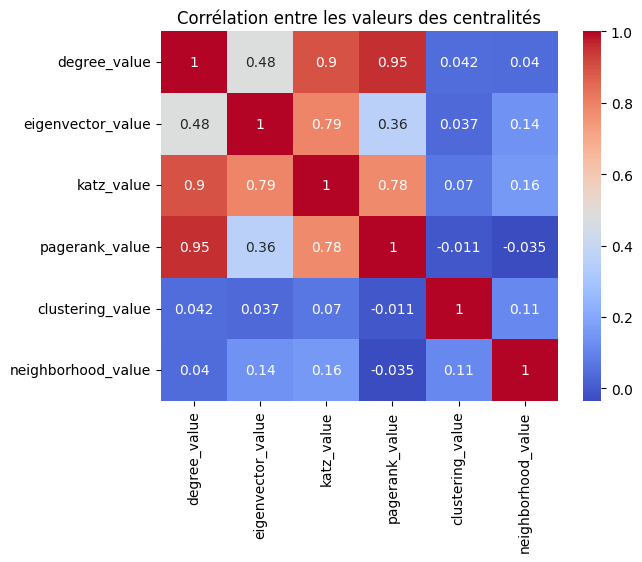

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Corrélation entre centralités (valeurs)
value_cols = [col for col in df.columns if col.endswith('_value')]
sns.heatmap(df[value_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre les valeurs des centralités")
plt.show()

On retrouve des résultats similaires au premier graph ce qui est cohérent puisque les deux graphs sont très similaires. Encore une fois on peut regrouper les quatres premières centralités.

Coefficient directeur : 3.0710005950829506
Ordonnée à l'origine : 0.00727902150329204


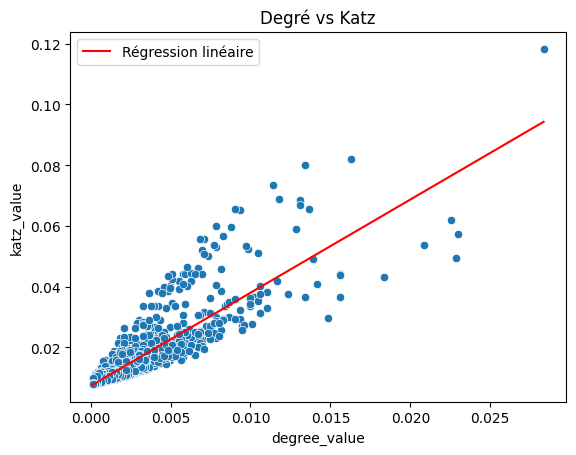

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

slope, intercept = np.polyfit(df['degree_value'], df['katz_value'], 1)

print(f"Coefficient directeur : {slope}")
print(f"Ordonnée à l'origine : {intercept}")

sns.scatterplot(x='degree_value', y='katz_value', data=df)
x_vals = np.linspace(df['degree_value'].min(), df['degree_value'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='red', label='Régression linéaire')
plt.title("Degré vs Katz")
plt.legend()
plt.show()

On retrouve une forte corrélation entre la degree_centrality et la katz_centrality, le rapport entre les deux centralités est proche de celui précedemment trouvé (proche de 4).

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df[value_cols]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Nœuds avec des valeurs particulièrement fortes/faibles
top_degree = df['degree_rank'].nsmallest(10)
low_pagerank = df['pagerank_rank'].nlargest(10)

special_nodes = list(set(top_degree.index) | set(low_pagerank.index))
df.loc[special_nodes]

,degree_value,degree_rank,eigenvector_value,eigenvector_rank,katz_value,katz_rank,pagerank_value,pagerank_rank,clustering_value,clustering_rank,neighborhood_value,neighborhood_rank,cluster
node,,,,,,,,,,,,,
4418,0.000131,7302,0.000082,3002,0.008199,5182,0.000029,7617,0.000000,7218,41.000000,1089,1
7237,0.028335,1,0.256119,1,0.118345,1,0.002581,4,0.071878,4063,25.837963,2483,0
5127,0.015611,10,0.001510,836,0.043957,40,0.001886,9,0.062384,4178,21.932773,3053,0
3464,0.000131,6061,0.003177,635,0.008680,3818,0.000029,7620,0.000000,4862,54.000000,597,1
3209,0.000131,7025,0.000062,3271,0.008121,5482,0.000029,7619,0.000000,6801,32.000000,1768,1
3530,0.022957,2,0.001847,772,0.057271,15,0.002719,3,0.041379,4280,18.228571,3638,0
1097,0.000131,6331,0.000044,3614,0.008029,5916,0.000029,7618,0.000000,5505,21.000000,3189,1
524,0.022563,4,0.005460,433,0.061954,11,0.001967,8,0.075955,4051,17.087209,3828,0
3597,0.016267,7,0.190780,3,0.082197,2,0.001435,13,0.128245,3631,31.330645,1820,0


Le noeud 7237 a le premier rang pour ce qui est du degree_rank, eigenvector_rank et katz_rank (4ème sur pagerank). 

Les neouds ayant une centralité grande par rapport aux autres ont été clusterisés par l'algorithme du k-means (k=3) dans le cluster 0 à l'inverse ceux avec une centralité faible ont été affecté au cluster 1.

# 3- Community detection

## 3.1- 8-clique community

8-clique communautés calculées
Nombre de 8-clique communautés : 10


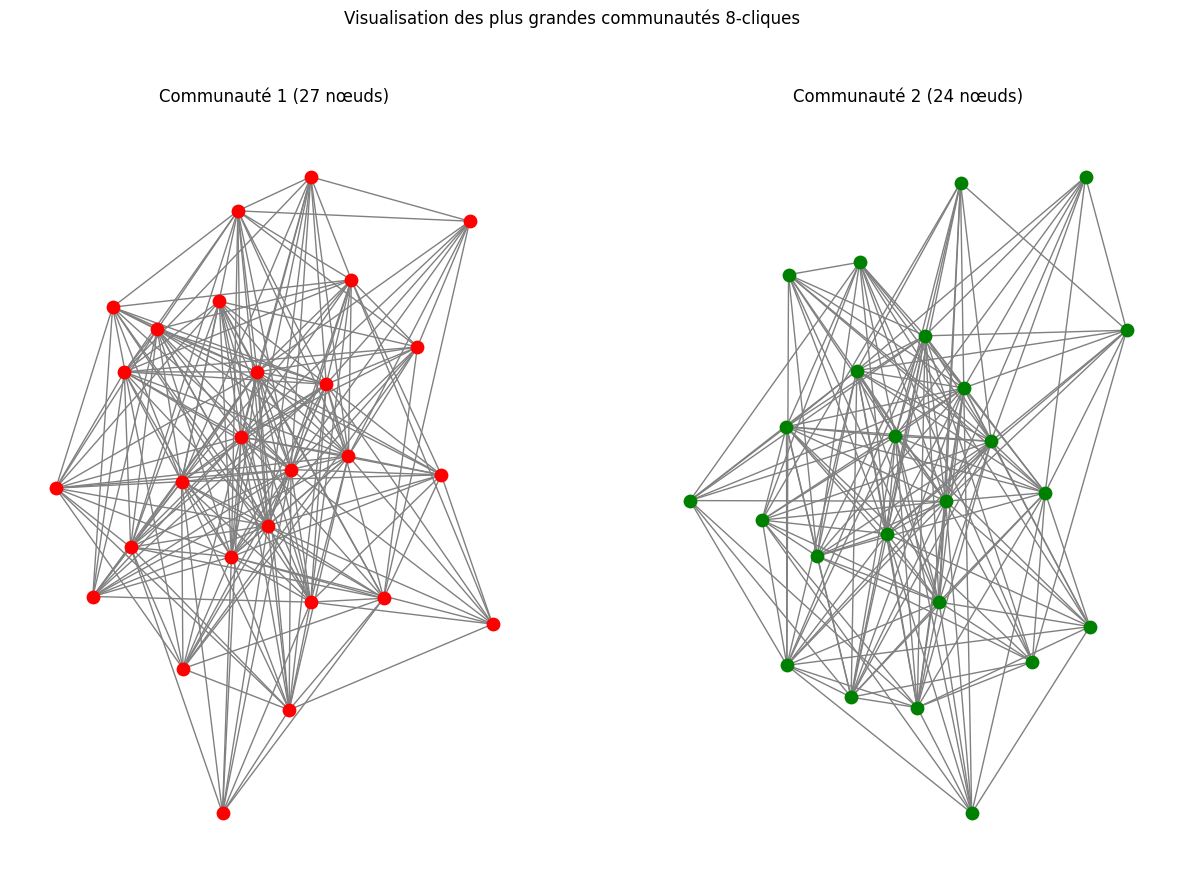

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import itertools

# Calcul des communautés 8-cliques
communities = sorted(list(nx.community.k_clique_communities(deezer_graph, 8)), key=len, reverse=True)
print("8-clique communautés calculées")
print(f"Nombre de 8-clique communautés : {len(communities)}")

# Sélectionner les k plus grandes communautés à afficher
k = min(2, len(communities))
communities = communities[:k]

colors = itertools.cycle(['r', 'g', 'b', 'c', 'm', 'y']) 

plt.figure(figsize=(15, 10))

for i, (community, color) in enumerate(zip(communities, colors), start=1):
    
    subgraph = deezer_graph.subgraph(community)
    pos = nx.spring_layout(subgraph, seed=42)
    
    # Dessiner le sous-graphe
    plt.subplot(1, k, i)
    nx.draw(subgraph, pos, node_color=color, edge_color='gray', with_labels=False, node_size=80)
    plt.title(f"Communauté {i} ({len(community)} nœuds)")

plt.suptitle("Visualisation des plus grandes communautés 8-cliques")
plt.show()



Plus grande clique trouvée (taille 11): [7323, 23361, 17819, 12565, 15141, 21798, 12056, 25901, 20953, 14559, 16986]


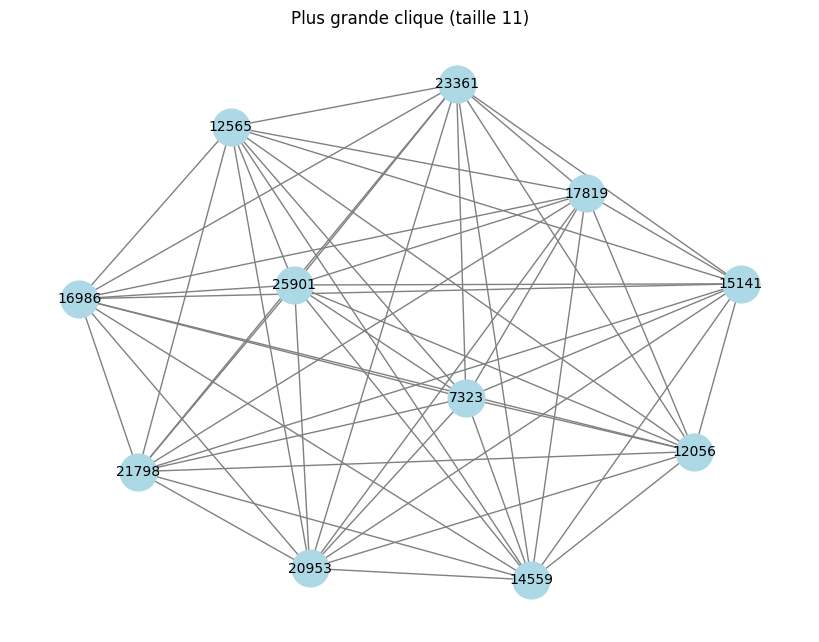

In [27]:
import matplotlib.pyplot as plt

maximal_cliques = list(nx.find_cliques(deezer_graph))
largest_clique = max(maximal_cliques, key=len)

print(f"Plus grande clique trouvée (taille {len(largest_clique)}):", largest_clique)

# Sous-graphe induit par la clique
clique_subgraph = deezer_graph.subgraph(largest_clique)

# Plot
pos = nx.spring_layout(clique_subgraph, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(clique_subgraph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
plt.title(f"Plus grande clique (taille {len(largest_clique)})")
plt.show()

## 3.2- Louvain communities

Nombre de communautés de Louvain trouvées :  84


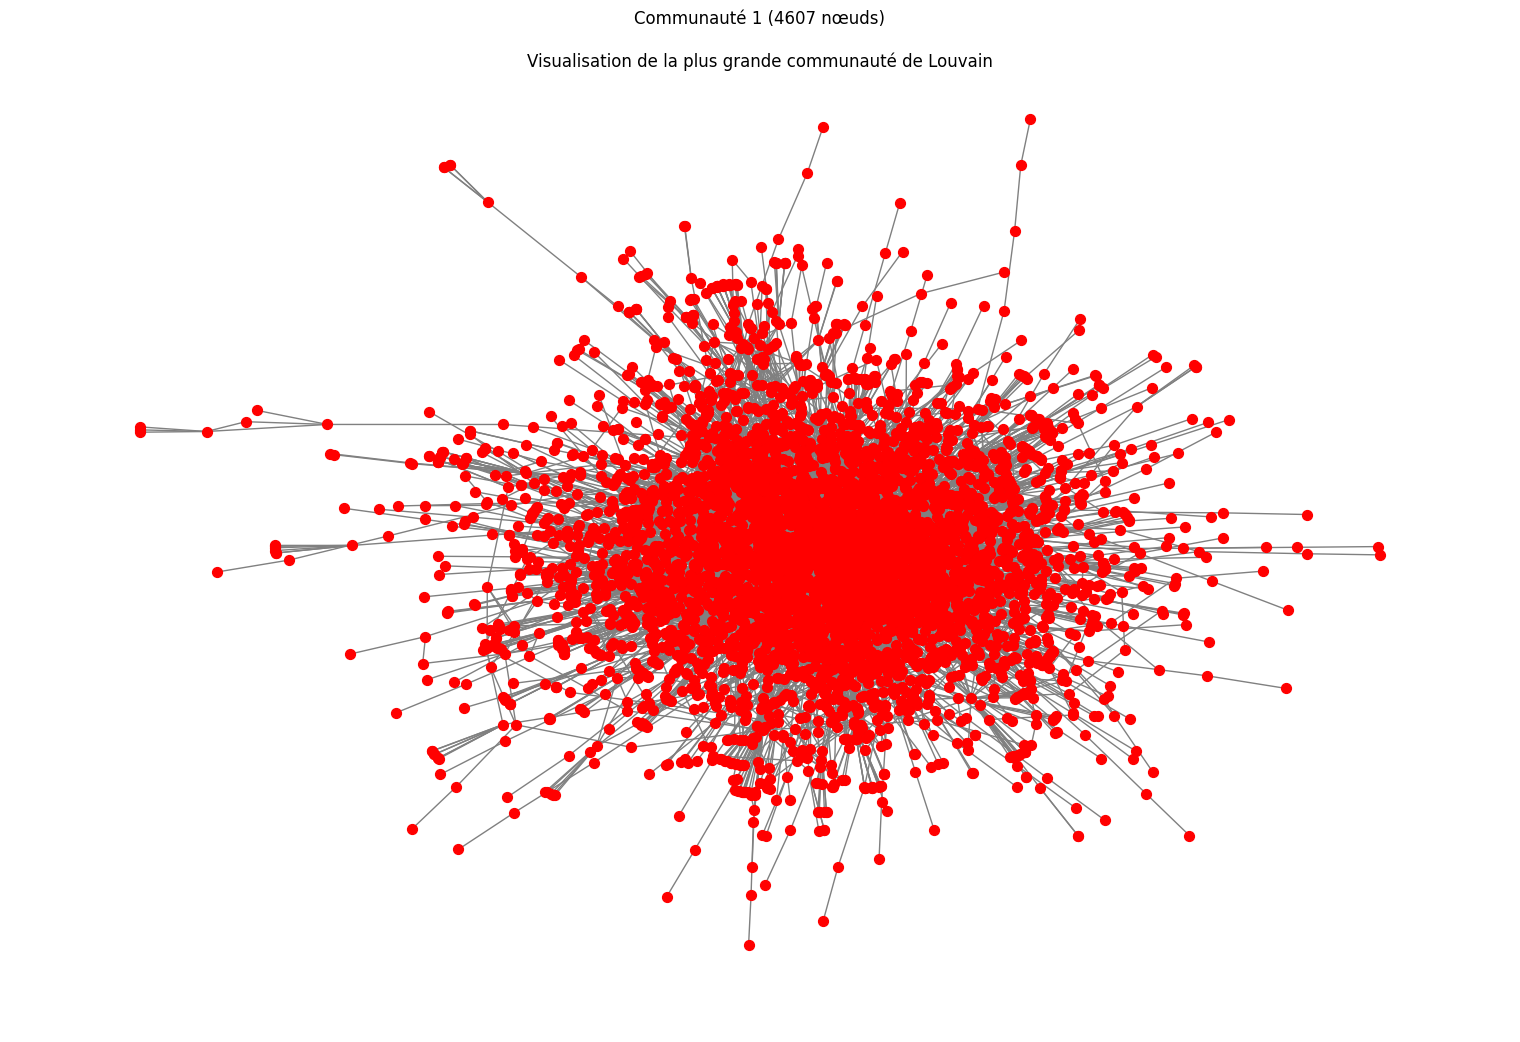

In [7]:
communities = sorted(list(nx.community.louvain_communities(deezer_graph)), key=len, reverse=True)
print("Nombre de communautés de Louvain trouvées : ", len(communities))

# Sélectionner les k plus grandes communautés à afficher
k = min(1, len(communities))
communities = communities[:k]

colors = itertools.cycle(['r', 'g', 'b', 'c', 'm', 'y']) 

plt.figure(figsize=(15, 10))

for i, (community, color) in enumerate(zip(communities, colors), start=1):
    subgraph = deezer_graph.subgraph(community)
    pos = nx.spring_layout(subgraph)
    
    # Dessiner le sous-graphe
    nx.draw(subgraph, pos, node_color=color, edge_color='gray', with_labels=False, node_size=50)
    plt.title(f"Communauté {i} ({len(community)} nœuds)")

plt.suptitle("Visualisation de la plus grande communauté de Louvain")
plt.show()


# 4- Embeddings

In [ ]:
import numpy as np

used_graph = deezer_graph

percent_nodes = 1 # Decrease for faster execution

if percent_nodes != 1 :
    n_nodes = int(used_graph.number_of_nodes() * percent_nodes)
    print(f"Selected nodes: {n_nodes} ({percent_nodes*100:.0f}%)")

    # Random walk sampling
    def random_walk_sampling(graph, start_node, walk_len, damping_factor=0.15):
        visited = {start_node}
        current_node = start_node
        for _ in range(walk_len):
            neighbors = list(graph.neighbors(current_node))
            if np.random.random()>damping_factor and neighbors:
                current_node = np.random.choice(neighbors)
                visited.add(current_node)
            else :
                current_node = np.random.choice(graph.nodes)
        return(visited)

    random_nodes = random_walk_sampling(used_graph,start_node=np.random.choice(used_graph.nodes),walk_len=n_nodes)
    used_graph = used_graph.subgraph(random_nodes)

print(used_graph)


Selected nodes: 2828 (10%)
Graph with 1866 nodes and 3425 edges


## 4.1- Node2Vec embedding

In [9]:
# Node2vec embedding
from collections import defaultdict
import networkx as nx
import numpy as np
import random
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine

class Node2vec:
    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 10,
                num_walks: int = 20, p: float = 1, q: float = 1, window_size: int = 5,
                min_count: int = 1, workers: int = 1, epochs: int = 10, quiet: bool = False):
        
        self.graph = graph
        self.dimensions =  dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.quiet = quiet

        self.p_graph = defaultdict(lambda: {'probabilities': {}})

        self._preprocess_modified_probs()
        if not self.quiet:
            print("Preprocessing des probabilités modifiées terminés.")
        self.walks = self._random_walk()
        if not self.quiet:
            print("Random walks calculées.")

        self.window_size = window_size
        self.min_count = min_count
        self.workers = workers
        self.epochs = epochs

        print("Entrainment du modèle Word2Vec pour calculer l'embedding.")
        self._train()
        print("Modèle entrainé.")


    def _preprocess_modified_probs(self):
        for origin_node in self.graph.nodes():

            for current_node in self.graph.neighbors(origin_node):
                unnormalized_probs = []

                for next_node in self.graph.neighbors(current_node):
                    if next_node == origin_node:
                        modified_prob = 1 / self.p
                    elif next_node in self.graph.neighbors(origin_node):
                        modified_prob = 1
                    else:
                        modified_prob = 1 / self.q

                    unnormalized_probs.append(modified_prob)

                # Normalisation
                if unnormalized_probs:
                    Z = abs(sum(unnormalized_probs))
                    normalized_probs = np.array([prob / Z for prob in unnormalized_probs])
                    self.p_graph[current_node]['probabilities'][origin_node] = normalized_probs

    def _random_walk(self) -> list:

        def _alias_setup(probs):

            N = len(probs)
            scaled_probs = [p * N for p in probs]
            prob = [0]*N
            alias = np.zeros(N, dtype=int) 

            small = []
            large = []

            for i, sp in enumerate(scaled_probs):
                if sp < 1: 
                    small.append(i)
                else:
                    large.append(i)

            while small and large:
                small_idx = small.pop()
                large_idx = large.pop()

                prob[small_idx] = scaled_probs[small_idx]
                alias[small_idx] = large_idx
                scaled_probs[large_idx] += (scaled_probs[small_idx] - 1)

                if scaled_probs[large_idx] < 1:
                    small.append(large_idx)
                else:
                    large.append(large_idx)

            return prob, alias

        def _choose_next(prob, alias):
            N = len(prob)
            i = np.random.randint(N)
            return i if np.random.rand() < prob[i] else alias[i]

        def _next_neighbor(current_node, origin_node, p_graph):
            neighbors = list(self.graph.neighbors(current_node))
            if not neighbors:
                return current_node
            
            prob = p_graph[current_node]['probabilities'][origin_node]
            prob, alias = _alias_setup(prob)

            next = _choose_next(prob, alias)
            return neighbors[next]
        
        def _compute_first_travel(node, p_graph):
            neighbors = list(self.graph.neighbors(node))
            return random.choice(neighbors) if neighbors else node

        walks = []
        for iter in range(self.num_walks):

            shuffled_nodes = list(self.graph.nodes())
            random.shuffle(shuffled_nodes)

            for node in shuffled_nodes:
                walk = [node]
                walk.append(_compute_first_travel(node, self.p_graph))
                for j in range(self.walk_length-1):
                    current_node, origin_node = walk[-1], walk[-2]
                    next = _next_neighbor(current_node, origin_node, self.p_graph)
                    walk.append(next)
                walks.append(walk)
        return walks
    
    def _train(self):
        walks_str = [[str(node) for node in walk] for walk in self.walks]
        self.model = Word2Vec(
            sentences=walks_str,
            vector_size=self.dimensions,
            window=self.window_size,
            min_count=self.min_count,
            sg=1,
            workers=self.workers,
            epochs=self.epochs
        )

    def get_embedding(self, node):
        return self.model.wv[str(node)] if str(node) in self.model.wv else None
    
    def cosine_similarity(self, node1, node2):
        emb1 = self.get_embedding(node1)
        emb2 = self.get_embedding(node2)
        
        if emb1 is None or emb2 is None:
            return None

        return 1 - cosine(emb1, emb2)


In [10]:
import node2vec as n2v

# Embedding Node2vec ci-dessus
node2vec_embedding = Node2vec(used_graph, p=0.2, q=1.2, workers=4, epochs=20)
print("Premier embedding calculé.")

# Embedding Node2vec de https://github.com/eliorc
node2vec_lib = n2v.node2vec.Node2Vec(used_graph, p=0.2, q=1.2, workers=4)
node2vec_model_lib =  node2vec_lib.fit(window=5, min_count=1)
print("Second embedding calculé.")

/Users/tombo/Desktop/CS_cours/graph_mining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocessing des probabilités modifiées terminés.
Random walks calculées.
Entrainment du modèle Word2Vec pour calculer l'embedding.
Modèle entrainé.
Premier embedding calculé.


Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


Second embedding calculé.


## 4.2- Spectral embedding

In [ ]:
import networkx as nx
import numpy as np
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt

# Calculer la matrice laplacienne
L = nx.laplacian_matrix(used_graph).astype(float)

# Calculer les valeurs propres et vecteurs propres
k = 100
eigenvalues, eigenvectors = linalg.eigsh(L, k=k, which='SM')
tolerance = 1e-14
eigenvalues = np.real(eigenvalues)
eigenvalues[np.abs(eigenvalues) < tolerance] = 0


In [ ]:
# Visualisation des valeurs propres pour trouver un gap spectral (vp_k << vp_k+1)
plt.scatter(np.arange(k), eigenvalues)
plt.axvline(x=71, color='red', linestyle='--', label='vp 71 (index)')
plt.axhline(y=eigenvalues[71], color='blue', linestyle='--', label=f'vp 71 (valeur: {eigenvalues[71]:.4f})')
plt.title("Valeurs propres")
plt.xlabel("Numéro valeur propre")
plt.ylabel("Valeur")
plt.legend()
plt.show()

Il y a un grand écart entre les valeurs propres numéro 71 et 72. On choisit donc de ne sélectionner que les 71 plus petites vp pour réaliser l'embedding (moins celle qui vaut 0).

In [ ]:
# Calculer les valeurs propres et vecteurs propres
chosen_k = 72
eigenvalues, eigenvectors = linalg.eigsh(L, k=chosen_k, which='SM')
# eigenvalues, eigenvectors = eigenvalues[chosen_k], eigenvectors[:, :chosen_k]

# Sélectionner les vecteurs propres correspondant aux plus petites valeurs propres (sauf la première qui est 0)
embedding_spectral = eigenvectors[:, 1:]

In [ ]:
embedding_node2vec = np.array([node2vec_embedding.get_embedding(node) for node in range(n_nodes)])
print(embedding_node2vec.shape)
print(embedding_spectral.shape)
# (28281, 128)
# (28281, 71)

# 5- Comparaison des embeddings

## 5.1- Comparaison des clusters dans l'espace des embeddings

<b>Les valeurs suivantes sont obtenues pour le graph deezer_graph entier et pourrait être différentes si l'on considère un sous-graphe.</b>

Détermination des hyperparamètres des algorithmes de clustering : number of clusters (k, KMeans), maximum distance (eps, DBSCAN)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

n_nodes = embedding_node2vec.shape[0]
# Fonction pour sélectionner le nombre de clusters pour K-means
def select_kmeans_n_clusters(embedding, explored_range=np.arange(n_nodes//100, n_nodes//10, 500)):
    inertia = []
    silhouette_scores = []
    for n_clusters in tqdm(explored_range):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(embedding)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(embedding, labels))

    # Méthode du coude
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(explored_range, inertia, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')

    # Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(explored_range, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')
    plt.show()

    # Retourner le nombre de clusters optimal basé sur le silhouette score
    optimal_n_clusters = np.argmax(silhouette_scores) + 2
    return optimal_n_clusters


# Sélection des hyperparamètres pour K-means
# Successivement cherché le coude et pris en compte le max de silhouette avec des intervalles de plus en plus précis
# explored_range = np.arange(50, 175, 30)
# print(explored_range, len(explored_range))
# select_kmeans_n_clusters(embedding_spectral, explored_range=explored_range)
optimal_n_clusters_spectral = 100 # prise en compte des deux indicateurs 

# explored_range = np.arange(50, 200, 30)
# print(explored_range, len(explored_range))
# select_kmeans_n_clusters(embedding_node2vec, explored_range=explored_range)
optimal_n_clusters_node2vec = optimal_n_clusters_spectral
# Aucun coude d'inertie ou pic d'inertie. Réutilisation du même paramètre pour simplifier la comparaison.


print("Optimal number of clusters for Spectral Embedding (K-means):", optimal_n_clusters_spectral)
print("Optimal number of clusters for Node2Vec Embedding (K-means):", optimal_n_clusters_node2vec)


In [ ]:

# Fonction pour sélectionner eps pour DBSCAN
def select_dbscan_eps(embedding, min_samples=5):
    neigh = NearestNeighbors(n_neighbors=min_samples)
    nbrs = neigh.fit(embedding)
    distances, _ = nbrs.kneighbors(embedding)

    # k-distance plot
    distances = np.sort(distances[:, min_samples - 1], axis=0)
    plt.plot(distances)
    plt.axhline(y=distances[int(len(distances) * 0.9)], color='red', linestyle='--', label=f'point à 90%')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{min_samples}-distance')
    plt.title('k-distance plot')
    plt.show()

    # Retourner eps basé sur le coude du k-distance plot
    # Cela peut être fait manuellement ou en utilisant une heuristique
    eps = distances[int(len(distances) * 0.9)]  # Exemple heuristique
    return eps

# Sélection des hyperparamètres pour DBSCAN
optimal_eps_spectral = select_dbscan_eps(embedding_spectral)
optimal_eps_node2vec = select_dbscan_eps(embedding_node2vec)


print("Optimal eps for Spectral Embedding (DBSCAN):", optimal_eps_spectral)
print("Optimal eps for Node2Vec Embedding (DBSCAN):", optimal_eps_node2vec)

# Optimal eps for Spectral Embedding (DBSCAN): 0.0017430409564679395
# Optimal eps for Node2Vec Embedding (DBSCAN): 4.739624500274658

In [ ]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans, DBSCAN
from networkx.algorithms.community import modularity
import matplotlib.pyplot as plt

def evaluate_clustering(embedding, graph, method='kmeans', n_clusters=2, eps=0.5, min_samples=5):
    if method == 'kmeans':
        clustering = KMeans(n_clusters=n_clusters, random_state=42)
        labels = clustering.fit_predict(embedding)
    elif method == 'dbscan':
        clustering = DBSCAN(eps=eps, min_samples=min_samples)
        labels = clustering.fit_predict(embedding)
    else:
        raise ValueError("Method must be 'kmeans' or 'dbscan'")

    # Calculer la modularité
    modularity_score = modularity(graph, [set(np.where(labels == i)[0]) for i in np.unique(labels) if i != -1]+[{j} for j,i in enumerate(labels) if i == -1])
    return labels, modularity_score

# Appliquer K-means et DBSCAN sur les embeddings spectral et node2vec
labels_spectral_kmeans, modularity_spectral_kmeans = evaluate_clustering(embedding_spectral, used_graph, method='kmeans', n_clusters=optimal_n_clusters_spectral, eps=optimal_eps_spectral)
labels_node2vec_kmeans, modularity_node2vec_kmeans = evaluate_clustering(embedding_node2vec, used_graph, method='kmeans', n_clusters=optimal_n_clusters_node2vec, eps=optimal_eps_node2vec)

labels_spectral_dbscan, modularity_spectral_dbscan = evaluate_clustering(embedding_spectral, used_graph, method='dbscan', n_clusters=optimal_n_clusters_spectral, eps=optimal_eps_spectral)
labels_node2vec_dbscan, modularity_node2vec_dbscan = evaluate_clustering(embedding_node2vec, used_graph, method='dbscan', n_clusters=optimal_n_clusters_node2vec, eps=optimal_eps_node2vec)

# Afficher les résultats
print("K-means - Spectral Embedding: Modularity =", modularity_spectral_kmeans)
print("K-means - Node2Vec Embedding: Modularity =", modularity_node2vec_kmeans)
print("DBSCAN - Spectral Embedding: Modularity =", modularity_spectral_dbscan)
print("DBSCAN - Node2Vec Embedding: Modularity =", modularity_node2vec_dbscan)

# K-means - Spectral Embedding: Modularity = 0.00010131904420685507
# K-means - Node2Vec Embedding: Modularity = 0.5823188650906954
# DBSCAN - Spectral Embedding: Modularity = -0.0006096588445744115
# DBSCAN - Node2Vec Embedding: Modularity = 0.000929680962462588

# Visualisation des clusters pour K-means
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(embedding_spectral[:, 0], embedding_spectral[:, 1], c=labels_spectral_kmeans, cmap='viridis')
plt.title("K-means - Spectral Embedding")

plt.subplot(1, 2, 2)
plt.scatter(embedding_node2vec[:, 0], embedding_node2vec[:, 1], c=labels_node2vec_kmeans, cmap='viridis')
plt.title("K-means - Node2Vec Embedding")

plt.show()

# Visualisation des clusters pour DBSCAN
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(embedding_spectral[:, 0], embedding_spectral[:, 1], c=labels_spectral_dbscan, cmap='viridis')
plt.title("DBSCAN - Spectral Embedding")

plt.subplot(1, 2, 2)
plt.scatter(embedding_node2vec[:, 0], embedding_node2vec[:, 1], c=labels_node2vec_dbscan, cmap='viridis')
plt.title("DBSCAN - Node2Vec Embedding")

plt.show()


Les différentes modularités sont extrêmement faibles, sauf KMeans-Node2Vec. Cela signifie que les clusters ne sont pas une bonne partition des graphs. Cela pourrait être dû aux embeddings ou alors au choix des hyperparamètres de clustering. <br>
Node2Vec semble tout de même supérieur par cette étude car cet embedding obtient la seule valeur assez grande.

## 5.2- Link prediction

In [ ]:
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import random

# Fonction pour créer des paires de nœuds et leurs étiquettes (1 si lien, 0 sinon)
def create_edge_samples(graph, embedding):
    edges = list(graph.edges())
    non_edges = list(nx.non_edges(graph))

    # Échantillonner un nombre égal de liens et de non-liens
    non_edges_sample = random.sample(non_edges, len(edges))

    # Créer les features pour les paires de nœuds
    edge_features = [np.abs(embedding[u] - embedding[v]) for u, v in edges]
    non_edge_features = [np.abs(embedding[u] - embedding[v]) for u, v in non_edges_sample]

    # Créer les labels
    edge_labels = [1] * len(edges)
    non_edge_labels = [0] * len(non_edges_sample)

    # Combiner les features et les labels
    features = np.array(edge_features + non_edge_features)
    labels = np.array(edge_labels + non_edge_labels)

    return features, labels

# Créer les échantillons pour les embeddings spectral et node2vec
features_spectral, labels_spectral = create_edge_samples(used_graph, embedding_spectral)
features_node2vec, labels_node2vec = create_edge_samples(used_graph, embedding_node2vec)

# Diviser les données en ensembles d'entraînement et de test
X_train_spectral, X_test_spectral, y_train_spectral, y_test_spectral = train_test_split(features_spectral, labels_spectral, test_size=0.2, random_state=42)
X_train_node2vec, X_test_node2vec, y_train_node2vec, y_test_node2vec = train_test_split(features_node2vec, labels_node2vec, test_size=0.2, random_state=42)

# Entraîner un modèle de régression logistique pour la prédiction de liens
model_spectral = LogisticRegression()
model_spectral.fit(X_train_spectral, y_train_spectral)
y_pred_spectral = model_spectral.predict_proba(X_test_spectral)[:, 1]

model_node2vec = LogisticRegression()
model_node2vec.fit(X_train_node2vec, y_train_node2vec)
y_pred_node2vec = model_node2vec.predict_proba(X_test_node2vec)[:, 1]

# Évaluer les performances avec l'AUC-ROC
auc_spectral = roc_auc_score(y_test_spectral, y_pred_spectral)
auc_node2vec = roc_auc_score(y_test_node2vec, y_pred_node2vec)

print("AUC-ROC pour Spectral Embedding:", auc_spectral)
print("AUC-ROC pour Node2Vec Embedding:", auc_node2vec)

# AUC-ROC pour Spectral Embedding: 0.5073123081402587
# AUC-ROC pour Node2Vec Embedding: 0.9926934878490318

On remarque que le modèle ne réussit pas à apprendre avec l'embedding spectral (50% d'AUC-ROC cad aléatoire). Tandis que le modèle est presque parfait pour l'embedding Node2Vec (99%).

En conclusion de cette partie, au vue des score de modularité et de prédiction de liens, l'embedding Node2Vec ressort bien plus performant que celui spectral. Il faudrait envisager d'autres mesures pour être plus confiant dans cette affirmation.

# 6- GNN-based approach

In [17]:
from graph_analysis.get_graphs import (
    deezer_pyg,
    lastfm_pyg,
    max_deezer_features,
    max_lastfm_features,
    max_lastfm_target,
)
import torch_geometric.nn as gnn
import torch.nn as nn
import torch

# Node : person. Edge : follow relationship. Features : likes.
print(deezer_pyg)  # Target : gender
print(lastfm_pyg)  # Target : country

Max target in LastFM: 17
Data(x=[28281, 1715], edge_index=[2, 185504], y=[28281])
Data(x=[7624, 944], edge_index=[2, 55612], y=[7624])


In [18]:
class GCN(nn.Module):
    def __init__(self, num_songs, emb_dim, hidden_dim, out_channels):
        super().__init__()
        self.embedding = nn.Embedding(num_songs + 1, emb_dim, padding_idx=num_songs)
        self.conv1 = gnn.GCNConv(emb_dim, hidden_dim)
        self.conv2 = gnn.GCNConv(hidden_dim, out_channels)

    def forward(self, graph):
        liked_lists = graph.x
        batch_embeddings = []

        for liked in liked_lists:
            song_embs = self.embedding(liked)
            mean_emb = song_embs.mean(dim=0)
            batch_embeddings.append(mean_emb)

        x = torch.stack(batch_embeddings)  # shape [num_nodes, emb_dim]

        x = self.conv1(x, graph.edge_index).relu()
        x = self.conv2(x, graph.edge_index)
        return x


deezer_model_1 = GCN(
    num_songs=max_deezer_features,
    emb_dim=30,
    hidden_dim=100,
    out_channels=1,
).to("mps")

In [19]:
class SAGE(nn.Module):
    def __init__(self, num_songs, emb_dim, hidden_dim, out_channels):
        super().__init__()
        self.embedding = nn.Embedding(num_songs + 1, emb_dim, padding_idx=num_songs)
        self.conv1 = gnn.SAGEConv(emb_dim, hidden_dim, normalize=True)
        self.conv2 = gnn.SAGEConv(hidden_dim, out_channels)

    def forward(self, graph):
        liked_lists = graph.x
        batch_embeddings = []

        for liked in liked_lists:
            song_embs = self.embedding(liked)
            mean_emb = song_embs.mean(dim=0)
            batch_embeddings.append(mean_emb)

        x = torch.stack(batch_embeddings)  # shape [num_nodes, emb_dim]

        x = self.conv1(x, graph.edge_index).relu()
        x = self.conv2(x, graph.edge_index)
        return x


deezer_model_2 = SAGE(
    num_songs=max_deezer_features,
    emb_dim=40,
    hidden_dim=100,
    out_channels=1,
).to("mps")

## 6.1- Deezer

In [20]:
# Split the data
train_ratio = 0.8
num_nodes = deezer_pyg.x.shape[0]
num_train = int(num_nodes * train_ratio)
idx = [i for i in range(num_nodes)]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

indices = list(range(num_nodes))
np.random.shuffle(indices)
split = int(0.8 * num_nodes)
train_mask[indices[:split]] = True
test_mask[indices[split:]] = True

deezer_pyg.train_mask = train_mask
deezer_pyg.test_mask = test_mask
print(train_mask)
print(test_mask)
# Get class balance
class_0_count = (deezer_pyg.y == 0).sum().item()
class_1_count = (deezer_pyg.y == 1).sum().item()
total = class_0_count + class_1_count
print(
    f"Class balance: {class_0_count/total:.2%} class 0, {class_1_count/total:.2%} class 1"
)

tensor([ True,  True, False,  ...,  True,  True,  True])
tensor([False, False,  True,  ..., False, False, False])
Class balance: 55.67% class 0, 44.33% class 1


In [21]:
criterion = torch.nn.BCEWithLogitsLoss().to("mps")
optimizer = torch.optim.Adam(deezer_model_1.parameters(), lr=1e-3, weight_decay=1e-5)
deezer_pyg = deezer_pyg.to("mps")

for epoch in tqdm(range(20), desc="Training"):
    deezer_model_1.train()
    optimizer.zero_grad()
    out = deezer_model_1(deezer_pyg).squeeze(-1)
    loss = criterion(
        out[deezer_pyg.train_mask], deezer_pyg.y[deezer_pyg.train_mask].float()
    )
    loss.backward()
    optimizer.step()

    if epoch % 4 == 0:
        pred = out.sigmoid() > 0.5
        acc = (
            (pred[deezer_pyg.test_mask] == deezer_pyg.y[deezer_pyg.test_mask].float())
            .float()
            .mean()
        )
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

    if epoch % 4 == 0:
        pred = out.sigmoid() > 0.5
        acc = (
            (pred[deezer_pyg.test_mask] == deezer_pyg.y[deezer_pyg.test_mask].float())
            .float()
            .mean()
        )
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

Training:   5%|▌         | 1/20 [00:21<06:41, 21.11s/it]

Epoch 000, Loss: 0.6932, Test Acc: 0.4460
Epoch 000, Loss: 0.6932, Test Acc: 0.4460


Training:  25%|██▌       | 5/20 [00:44<01:47,  7.19s/it]

Epoch 004, Loss: 0.6914, Test Acc: 0.5570
Epoch 004, Loss: 0.6914, Test Acc: 0.5570


Training:  45%|████▌     | 9/20 [01:08<01:07,  6.17s/it]

Epoch 008, Loss: 0.6897, Test Acc: 0.5570
Epoch 008, Loss: 0.6897, Test Acc: 0.5570


Training:  65%|██████▌   | 13/20 [01:32<00:42,  6.13s/it]

Epoch 012, Loss: 0.6882, Test Acc: 0.5570
Epoch 012, Loss: 0.6882, Test Acc: 0.5570


Training:  85%|████████▌ | 17/20 [01:57<00:19,  6.36s/it]

Epoch 016, Loss: 0.6871, Test Acc: 0.5570
Epoch 016, Loss: 0.6871, Test Acc: 0.5570


Training: 100%|██████████| 20/20 [02:14<00:00,  6.74s/it]


In [22]:
criterion = torch.nn.BCEWithLogitsLoss().to("mps")
optimizer = torch.optim.Adam(deezer_model_2.parameters(), lr=1e-3, weight_decay=1e-5)
deezer_pyg = deezer_pyg.to("mps")

for epoch in tqdm(range(20), desc="Training"):
    deezer_model_2.train()
    optimizer.zero_grad()
    out = deezer_model_2(deezer_pyg).squeeze(-1)
    loss = criterion(
        out[deezer_pyg.train_mask], deezer_pyg.y[deezer_pyg.train_mask].float()
    )
    loss.backward()
    optimizer.step()

    if epoch % 4 == 0:
        pred = out.sigmoid() > 0.5
        acc = (
            (pred[deezer_pyg.test_mask] == deezer_pyg.y[deezer_pyg.test_mask].float())
            .float()
            .mean()
        )
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

    if epoch % 4 == 0:
        pred = out.sigmoid() > 0.5
        acc = (
            (pred[deezer_pyg.test_mask] == deezer_pyg.y[deezer_pyg.test_mask].float())
            .float()
            .mean()
        )
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

Training:   5%|▌         | 1/20 [00:10<03:20, 10.55s/it]

Epoch 000, Loss: 0.6989, Test Acc: 0.4430
Epoch 000, Loss: 0.6989, Test Acc: 0.4430


Training:  25%|██▌       | 5/20 [00:44<02:13,  8.87s/it]

Epoch 004, Loss: 0.6949, Test Acc: 0.4430
Epoch 004, Loss: 0.6949, Test Acc: 0.4430


Training:  45%|████▌     | 9/20 [01:18<01:35,  8.66s/it]

Epoch 008, Loss: 0.6915, Test Acc: 0.5570
Epoch 008, Loss: 0.6915, Test Acc: 0.5570


Training:  65%|██████▌   | 13/20 [01:52<00:59,  8.51s/it]

Epoch 012, Loss: 0.6887, Test Acc: 0.5570
Epoch 012, Loss: 0.6887, Test Acc: 0.5570


Training:  85%|████████▌ | 17/20 [02:27<00:25,  8.63s/it]

Epoch 016, Loss: 0.6870, Test Acc: 0.5570
Epoch 016, Loss: 0.6870, Test Acc: 0.5570


Training: 100%|██████████| 20/20 [02:55<00:00,  8.78s/it]


## 6.2- LastFM

In [23]:
# Split the data
train_ratio = 0.8
num_nodes = lastfm_pyg.x.shape[0]
num_train = int(num_nodes * train_ratio)
idx = [i for i in range(num_nodes)]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

indices = list(range(num_nodes))
np.random.shuffle(indices)
split = int(0.8 * num_nodes)
train_mask[indices[:split]] = True
test_mask[indices[split:]] = True

lastfm_pyg.train_mask = train_mask
lastfm_pyg.test_mask = test_mask
print(train_mask)
print(test_mask)

tensor([False,  True,  True,  ...,  True,  True,  True])
tensor([ True, False, False,  ..., False, False, False])


In [24]:
model_lastfm_1 = GCN(max_lastfm_features, 30, 10, max_lastfm_target).to("mps")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lastfm_1.parameters())

for epoch in tqdm(range(20), desc="Training"):
    model_lastfm_1.train()
    optimizer.zero_grad()
    out:torch.FloatTensor = model_lastfm_1(lastfm_pyg).squeeze(-1)
    loss = criterion(
        out[lastfm_pyg.train_mask], lastfm_pyg.y[lastfm_pyg.train_mask].float()
    )
    loss.backward()
    optimizer.step()

    if epoch % 4 == 0:
        pred = out.log_softmax(dim=1).argmax(dim=1)
        acc = (
            (pred[lastfm_pyg.test_mask] == lastfm_pyg.y[lastfm_pyg.test_mask].float())
            .float()
            .mean()
        )
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

    if epoch % 4 == 0:
        pred = out.log_softmax(dim=1).argmax(dim=1)
        acc = (
            (pred[lastfm_pyg.test_mask] == lastfm_pyg.y[lastfm_pyg.test_mask].float())
            .float()
            .mean()
        )
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")



Training:   0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
model_lastfm_1 = SAGE(max_lastfm_features, 30, 10, max_lastfm_target).to("mps")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lastfm_1.parameters())

for epoch in tqdm(range(20), desc="Training"):
    model_lastfm_1.train()
    optimizer.zero_grad()
    out:torch.FloatTensor = model_lastfm_1(lastfm_pyg).squeeze(-1)
    loss = criterion(
        out[lastfm_pyg.train_mask], lastfm_pyg.y[lastfm_pyg.train_mask].float()
    )
    loss.backward()
    optimizer.step()

    if epoch % 4 == 0:
        pred = out.log_softmax(dim=1).argmax(dim=1)
        acc = (
            (pred[lastfm_pyg.test_mask] == lastfm_pyg.y[lastfm_pyg.test_mask].float())
            .float()
            .mean()
        )
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

    if epoch % 4 == 0:
        pred = out.log_softmax(dim=1).argmax(dim=1)
        acc = (
            (pred[lastfm_pyg.test_mask] == lastfm_pyg.y[lastfm_pyg.test_mask].float())
            .float()
            .mean()
        )
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")



In [ ]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
modelSAGE = GraphSAGE(in_channels=pyg_graph_deezer.feat.shape[1],
            hidden_channels=128,
            out_channels=pyg_graph_deezer.target.max().item()+1)